# About

I reused my notebook in Tabular Playground Series - Jan 2021:  
https://www.kaggle.com/ttahara/tps-jan-2021-gbdts-baseline

<br>

* GBDT Models baseline
    * LightGBM, XGBoost, CatBoost
    * each model is trained by 5 folds cross validation 


* feature engineering
    * **label-encoding** for category features
    * no feature engineering for continuous features


* inference test by weighted averaging 3 GBDT Models(5 folds averaging)

<br>

There is a lot of room for improvement such as feature engineering, parameter tuning, other models, and so on. enjoy ;) 


# Prepare

## import libraries

In [22]:
import os
import sys
import time
import random
import logging
import typing as tp
from pathlib import Path
from contextlib import contextmanager

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import category_encoders as ce
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoost, Pool
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [23]:
np.log2(244)

7.930737337562887

## read data

In [25]:
train = pd.read_csv('..\\kaggle_data\\train.csv')
test = pd.read_csv('..\\kaggle_data\\test.csv')
smpl_sub = pd.read_csv('..\\kaggle_data\\sample_submission.csv')
print("train: {}, test: {}, sample sub: {}".format(
    train.shape, test.shape, smpl_sub.shape
))

train: (300000, 26), test: (200000, 25), sample sub: (200000, 2)


In [7]:
train = train2[(np.abs(stats.zscore(train2['target'])) < 3.0)]

In [26]:
train.head().T

,0,1,2,3,4
id,1,2,3,4,6
cat0,A,B,A,A,A
cat1,B,A,A,A,B
cat2,A,A,A,A,A
cat3,A,A,C,C,A
cat4,B,B,B,B,B
cat5,D,B,D,D,B
cat6,A,A,A,A,A
cat7,E,E,B,E,E
cat8,C,A,C,G,C


## Definition

In [27]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time.time()
    yield
    d = time.time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [28]:
class TreeModel:
    """Wrapper for LightGBM/XGBoost/CATBoost"""
    def __init__(self, model_type: str):
        self.model_type = model_type
        self.trn_data = None
        self.val_data = None
        self.model = None

    def train(self,
              params: dict,
              X_train: pd.DataFrame, y_train: np.ndarray,
              X_val: pd.DataFrame, y_val: np.ndarray,
              train_weight: tp.Optional[np.ndarray] = None,
              val_weight: tp.Optional[np.ndarray] = None,
              train_params: dict = None,
              cat_cols: list = None,
            ):
        if self.model_type == "lgb":
            self.trn_data = lgb.Dataset(X_train, label=y_train, weight=train_weight)
            self.val_data = lgb.Dataset(X_val, label=y_val, weight=val_weight)
            self.model = lgb.train(params=params,
                                   train_set=self.trn_data,
                                   valid_sets=[self.trn_data, self.val_data],
                                   **train_params)
        elif self.model_type == "xgb":
            self.trn_data = xgb.DMatrix(X_train, y_train, weight=train_weight)
            self.val_data = xgb.DMatrix(X_val, y_val, weight=val_weight)
            self.model = xgb.train(params=params,
                                   dtrain=self.trn_data,
                                   evals=[(self.trn_data, "train"), (self.val_data, "val")],
                                   **train_params)
        elif self.model_type == "cat":
            self.trn_data = Pool(
                X_train, label=y_train, cat_features=cat_cols)  #, group_id=[0] * len(X_train))
            self.val_data = Pool(
                X_val, label=y_val, cat_features=cat_cols)  #, group_id=[0] * len(X_val))
            self.model = CatBoost(params)
            self.model.fit(
                self.trn_data, eval_set=[self.val_data], use_best_model=True, **train_params)
        else:
            raise NotImplementedError

    def predict(self, X: pd.DataFrame):
        if self.model_type == "lgb":
            return self.model.predict(
                X, num_iteration=self.model.best_iteration)  # type: ignore
        elif self.model_type == "xgb":
            X_DM = xgb.DMatrix(X)
            return self.model.predict(
                X_DM, ntree_limit=self.model.best_ntree_limit)  # type: ignore
        elif self.model_type == "cat":
            return self.model.predict(X)
        else:
            raise NotImplementedError

    @property
    def feature_names_(self):
        if self.model_type == "lgb":
            return self.model.feature_name()
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").keys())
        elif self.model_type == "cat":
             return self.model.feature_names_
        else:
            raise NotImplementedError

    @property
    def feature_importances_(self):
        if self.model_type == "lgb":
            return self.model.feature_importance(importance_type="gain")
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").values())
        elif self.model_type == "cat":
            return self.model.feature_importances_
        else:
            raise NotImplementedError

# Training & Inference

## Config 

In [29]:
ID_COL = "id"
CAT_COLS= [f"cat{i}" for i in range(10)]
CONT_COLS = [f"cont{i}" for i in range(14)]
TGT_COL = "target"

N_SPLITS = 5
RANDOM_SEED_LIST = [
    42,
#     2021, 0, 1086, 39
]

MODEL_PARAMS = {
    "lgb": {
        "objective": "root_mean_squared_error",
        "boosting": "gbdt",
        "max_depth": 8,
        "learning_rate": 0.01,
        "colsample_bytree": 0.4,
        "subsample": 0.6,
        "subsample_freq": 6,
        "reg_alpha": 6,
        "min_data_in_leaf": 100,
        "n_jobs": 2,
        "seed": RANDOM_SEED_LIST[0],
        # "device": "gpu",
        # "gpu_device_id": 0
    },
    "xgb": {
        "objective": "reg:squarederror",
        "max_depth": 6,
        "learning_rate": 0.01,
        "colsample_bytree": 0.4,
        "subsample": 0.6,
        "reg_alpha" : 6,
        "min_child_weight": 100,
        "n_jobs": 2,
        "seed": RANDOM_SEED_LIST[0],
        'tree_method': "gpu_hist",
        "gpu_id": 0,
    },
    "cat": {
        'loss_function': 'RMSE',
        "max_depth": 4,
        'learning_rate': 0.05,
        "colsample_bylevel": 0.4,
        "subsample": 0.6,
        "min_child_samples": 100, 
        'random_state': RANDOM_SEED_LIST[0],
        "thread_count": 2,
#         "task_type": "GPU",
#         "devices" : "0",
        'num_boost_round': 20000,
    }
}
TRAIN_PARAMS = {
    "lgb": {
        "num_boost_round": 20000,
        "early_stopping_rounds": 200,
        "verbose_eval": 200,
    },
    "xgb": {
        "num_boost_round": 20000,
        "early_stopping_rounds": 200,
        "verbose_eval":  200,
    },
    "cat": {
        'early_stopping_rounds': 200,
        'verbose_eval': 200,
    }
}

## Feature Engineering

In [30]:
use_feat_cols = []
train_feat = train[[ID_COL]].copy()
test_feat = test[[ID_COL]].copy()

### for categorical features

apply label encoding using [`category_encoders.OrdinalEncoder`](https://contrib.scikit-learn.org/category_encoders/ordinal.html)

In [31]:
ord_enc = ce.OrdinalEncoder(cols=CAT_COLS)
train_cat_feat = ord_enc.fit_transform(train[CAT_COLS])
test_cat_feat = ord_enc.transform(test[CAT_COLS])

c:\users\ryans\source\repos\venvs\python375\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [32]:
train_feat = pd.concat([
    train_feat, train_cat_feat], axis=1)
test_feat = pd.concat([
    test_feat, test_cat_feat], axis=1)
use_feat_cols.extend(train_cat_feat.columns)

### for continuous features

Use them as they are

In [33]:
train_cont_feat = train[CONT_COLS]
test_cont_feat = test[CONT_COLS]

In [34]:
train_feat = pd.concat([
    train_feat, train_cont_feat], axis=1)
test_feat = pd.concat([
    test_feat, test_cont_feat], axis=1)
use_feat_cols.extend(CONT_COLS)

In [35]:
train_feat.head().T

,0,1,2,3,4
id,1.000000,2.000000,3.000000,4.000000,6.000000
cat0,1.000000,2.000000,1.000000,1.000000,1.000000
cat1,1.000000,2.000000,2.000000,2.000000,1.000000
cat2,1.000000,1.000000,1.000000,1.000000,1.000000
cat3,1.000000,1.000000,2.000000,2.000000,1.000000
cat4,1.000000,1.000000,1.000000,1.000000,1.000000
cat5,1.000000,2.000000,1.000000,1.000000,2.000000
cat6,1.000000,1.000000,1.000000,1.000000,1.000000
cat7,1.000000,1.000000,2.000000,1.000000,1.000000
cat8,1.000000,2.000000,1.000000,3.000000,1.000000


In [36]:
test_feat.head().T

,0,1,2,3,4
id,0.000000,5.000000,15.000000,16.000000,17.000000
cat0,1.000000,1.000000,1.000000,1.000000,1.000000
cat1,1.000000,1.000000,1.000000,2.000000,1.000000
cat2,1.000000,1.000000,1.000000,2.000000,1.000000
cat3,2.000000,2.000000,2.000000,1.000000,1.000000
cat4,1.000000,1.000000,1.000000,1.000000,1.000000
cat5,1.000000,1.000000,1.000000,1.000000,2.000000
cat6,1.000000,1.000000,1.000000,1.000000,1.000000
cat7,1.000000,1.000000,1.000000,1.000000,1.000000
cat8,4.000000,1.000000,1.000000,4.000000,4.000000


## Training

In [37]:
def run_train_and_inference(
    X, X_test, y, use_model, model_params, train_params, seed_list, n_splits, cat_cols=None
):
    
    oof_pred_arr = np.zeros(len(X))
    test_pred_arr = np.zeros(len(X_test))
    feature_importances = pd.DataFrame()
    score_list = []
    
    for seed in seed_list:
        if use_model == "cat":
            model_params['random_state'] = seed
        else:
            model_params["seed"] = seed
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        tmp_oof_pred = np.zeros(len(X))
        tmp_test_pred = np.zeros(len(X_test))

        for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
            print("*" * 100)
            print(f"Seed: {seed} - Fold: {fold}")
            X_trn = X.loc[trn_idx].reset_index(drop=True)
            X_val = X.loc[val_idx].reset_index(drop=True)
            y_trn = y[trn_idx]
            y_val = y[val_idx]

            model = TreeModel(model_type=use_model)
            with timer(prefix="Model training"):
                model.train(
                    params=model_params, X_train=X_trn, y_train=y_trn,
                    X_val=X_val, y_val=y_val, train_params=train_params, cat_cols=cat_cols
                )
            fi_tmp = pd.DataFrame()
            fi_tmp["feature"] = model.feature_names_
            fi_tmp["importance"] = model.feature_importances_
            fi_tmp["fold"] = fold
            fi_tmp["seed"] = seed
            feature_importances = feature_importances.append(fi_tmp)

            val_pred = model.predict(X_val)
            score = mean_squared_error(y_val, val_pred, squared=False)
            print(f"score: {score:.5f}")
            score_list.append([seed, fold, score])
            tmp_oof_pred[val_idx] = val_pred
            tmp_test_pred += model.predict(X_test)
            
        oof_score = mean_squared_error(y, tmp_oof_pred, squared=False)
        print(f"oof score: {oof_score: 5f}")
        score_list.append([seed, "oof", oof_score])

        oof_pred_arr += tmp_oof_pred
        test_pred_arr += tmp_test_pred / n_splits

    oof_pred_arr /= len(seed_list)
    test_pred_arr /= len(seed_list)
    
    oof_score = mean_squared_error(y, oof_pred_arr, squared=False)
    score_list.append(["avg", "oof", oof_score])
    score_df = pd.DataFrame(
        score_list, columns=["seed", "fold", "rmse score"])
    
    return oof_pred_arr, test_pred_arr, score_df, feature_importances

In [38]:
X = train_feat[use_feat_cols]
X_test = test_feat[use_feat_cols]

y = train[TGT_COL].values

print(f"train_feat: {X.shape}, test_feat: {X_test.shape}")

train_feat: (300000, 24), test_feat: (200000, 24)


### LightGBM

In [39]:
oof_pred_lgb, test_pred_lgb, score_lgb, feat_imps_lgb = run_train_and_inference(
    X, X_test, y, "lgb", MODEL_PARAMS["lgb"], TRAIN_PARAMS["lgb"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 42 - Fold: 0
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3634
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 24
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 7.456400
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.858867	valid_1's rmse: 0.860831
[400]	training's rmse: 0.

In [40]:
score_lgb

,seed,fold,rmse score
0,42,0,0.842322
1,42,1,0.844142
2,42,2,0.842745
3,42,3,0.841683
4,42,4,0.840899
5,42,oof,0.842359
6,avg,oof,0.842359


In [41]:
score_lgb.loc[score_lgb.fold == "oof"]

,seed,fold,rmse score
5,42,oof,0.842359
6,avg,oof,0.842359


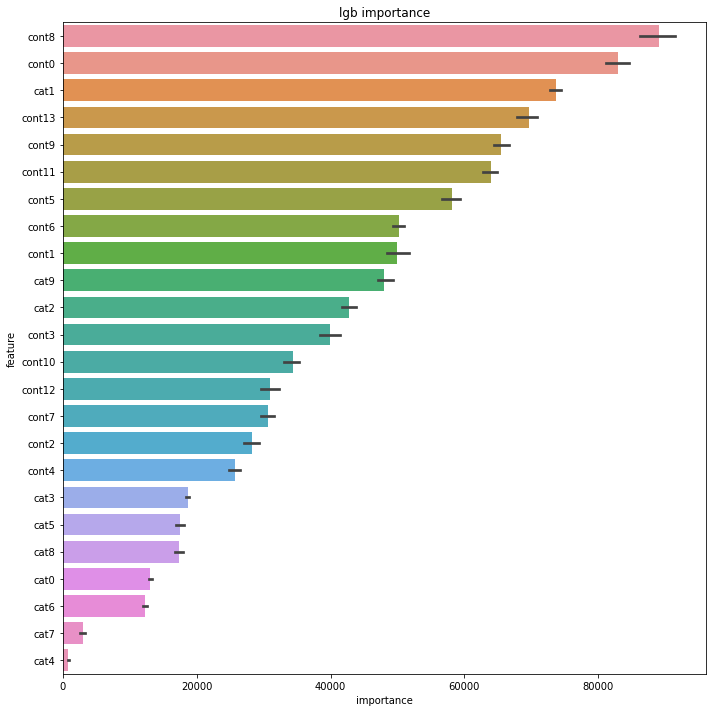

In [42]:
order = list(feat_imps_lgb.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_lgb, order=order)
plt.title("{} importance".format("lgb"))
plt.tight_layout()

### XGBoost

In [43]:
oof_pred_xgb, test_pred_xgb, score_xgb, feat_imps_xgb = run_train_and_inference(
    X, X_test, y, "xgb", MODEL_PARAMS["xgb"], TRAIN_PARAMS["xgb"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 42 - Fold: 0
[0]	train-rmse:6.94369	val-rmse:6.94320
[200]	train-rmse:1.26436	val-rmse:1.26454
[400]	train-rmse:0.86184	val-rmse:0.86398
[600]	train-rmse:0.84691	val-rmse:0.85065
[800]	train-rmse:0.84268	val-rmse:0.84793
[1000]	train-rmse:0.83950	val-rmse:0.84627
[1200]	train-rmse:0.83691	val-rmse:0.84515
[1400]	train-rmse:0.83459	val-rmse:0.84435
[1600]	train-rmse:0.83262	val-rmse:0.84376
[1800]	train-rmse:0.83076	val-rmse:0.84335
[2000]	train-rmse:0.82905	val-rmse:0.84305
[2200]	train-rmse:0.82746	val-rmse:0.84287
[2400]	train-rmse:0.82592	val-rmse:0.84266
[2600]	train-rmse:0.82448	val-rmse:0.84254
[2800]	train-rmse:0.82303	val-rmse:0.84243
[3000]	train-rmse:0.82168	val-rmse:0.84239
[3200]	train-rmse:0.82033	val-rmse:0.84233
[3400]	train-rmse:0.81902	val-rmse:0.84236
[3450]	train-rmse:0.81869	val-rmse:0.84237
Model training33.309[s]
score: 0.84233
*******************************

In [44]:
score_xgb

,seed,fold,rmse score
0,42,0,0.842332
1,42,1,0.844205
2,42,2,0.842925
3,42,3,0.841656
4,42,4,0.840798
5,42,oof,0.842384
6,avg,oof,0.842384


In [45]:
score_xgb.loc[score_xgb.fold == "oof"]

,seed,fold,rmse score
5,42,oof,0.842384
6,avg,oof,0.842384


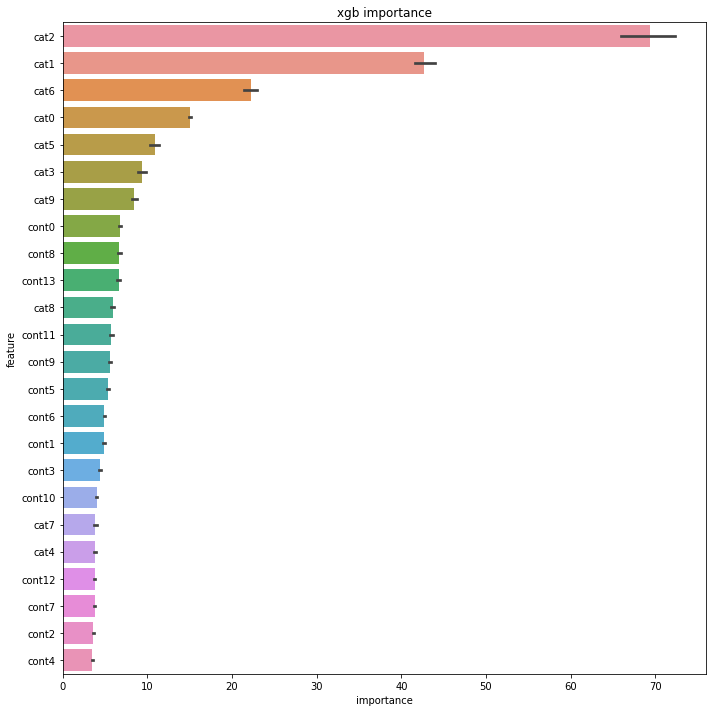

In [46]:
order = list(feat_imps_xgb.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_xgb, order=order)
plt.title("{} importance".format("xgb"))
plt.tight_layout()

### CatBoost

In [47]:
oof_pred_cat, test_pred_cat, score_cat, feat_imps_cat = run_train_and_inference(
    X, X_test, y, "cat", MODEL_PARAMS["cat"], TRAIN_PARAMS["cat"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 42 - Fold: 0
0:	learn: 0.8862917	test: 0.8878392	best: 0.8878392 (0)	total: 91.6ms	remaining: 30m 32s
200:	learn: 0.8531406	test: 0.8535632	best: 0.8535632 (200)	total: 5.84s	remaining: 9m 35s
400:	learn: 0.8478331	test: 0.8489703	best: 0.8489703 (400)	total: 11.6s	remaining: 9m 27s
600:	learn: 0.8447635	test: 0.8467624	best: 0.8467624 (600)	total: 17.2s	remaining: 9m 14s
800:	learn: 0.8426319	test: 0.8455110	best: 0.8455110 (800)	total: 22.9s	remaining: 9m 9s
1000:	learn: 0.8409362	test: 0.8445879	best: 0.8445879 (1000)	total: 28.5s	remaining: 9m
1200:	learn: 0.8395283	test: 0.8440312	best: 0.8440312 (1200)	total: 34.5s	remaining: 8m 59s
1400:	learn: 0.8382690	test: 0.8436926	best: 0.8436926 (1400)	total: 40.2s	remaining: 8m 53s
1600:	learn: 0.8371110	test: 0.8433794	best: 0.8433791 (1599)	total: 46.2s	remaining: 8m 50s
1800:	learn: 0.8360446	test: 0.8431788	best: 0.8431788 (1800

In [48]:
score_cat

,seed,fold,rmse score
0,42,0,0.842666
1,42,1,0.844927
2,42,2,0.843741
3,42,3,0.842567
4,42,4,0.841753
5,42,oof,0.843132
6,avg,oof,0.843132


In [49]:
score_cat.loc[score_cat.fold == "oof"]

,seed,fold,rmse score
5,42,oof,0.843132
6,avg,oof,0.843132


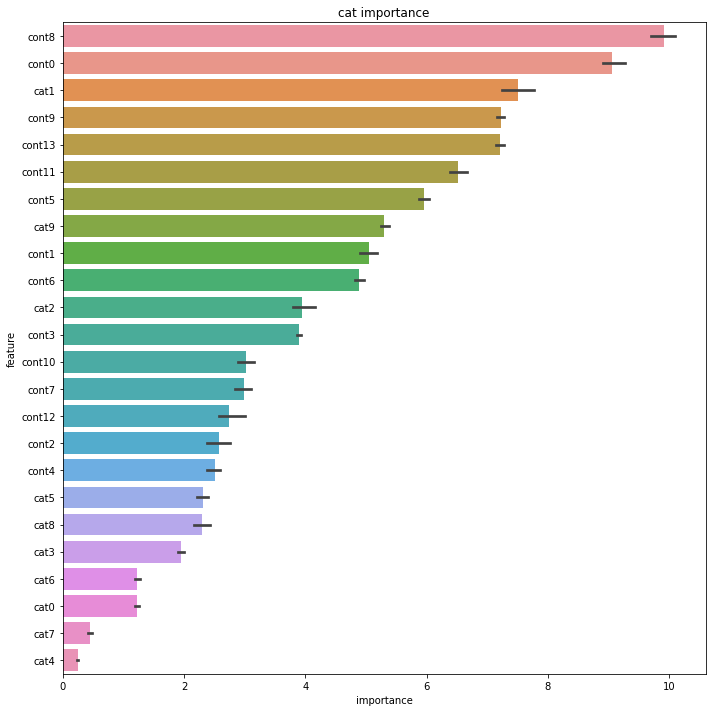

In [50]:
order = list(feat_imps_cat.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_cat, order=order)
plt.title("{} importance".format("cat"))
plt.tight_layout()

### Ensemble LGB, XGB, Cat

### check correlation

In [51]:
model_names = ["lgb", "xgb", "cat"]

In [52]:
# # prediction for oof
pd.DataFrame(
    np.corrcoef([
        oof_pred_lgb,
        oof_pred_xgb,
        oof_pred_cat
    ]),
    columns=model_names, index=model_names)

,lgb,xgb,cat
lgb,1.000000,0.994147,0.985922
xgb,0.994147,1.000000,0.987152
cat,0.985922,0.987152,1.000000


In [53]:
# # prediction for test
pd.DataFrame(
    np.corrcoef([
        test_pred_lgb,
        test_pred_xgb,
        test_pred_cat
    ]),
    columns=model_names, index=model_names)

,lgb,xgb,cat
lgb,1.000000,0.997871,0.991692
xgb,0.997871,1.000000,0.992570
cat,0.991692,0.992570,1.000000


### simple averaging

In [54]:
oof_pred_avg = (oof_pred_lgb + oof_pred_xgb + oof_pred_cat) / 3
oof_score_avg = mean_squared_error(y, oof_pred_avg, squared=False)

print(f"oof score avg: {oof_score_avg:.5f}")

oof score avg: 0.84230


In [55]:
test_pred_avg = (test_pred_lgb + test_pred_xgb + test_pred_cat) / 3

### weighted averaging

In [56]:
weights = [0.5, 0.4, 0.1]

In [57]:
oof_pred_wavg = weights[0] * oof_pred_lgb + weights[1] * oof_pred_xgb + weights[2] * oof_pred_cat
oof_score_wavg = mean_squared_error(y, oof_pred_wavg, squared=False)

print(f"oof score weighted avg: {oof_score_wavg:.5f}")

oof score weighted avg: 0.84223


In [58]:
test_pred_wavg = weights[0] * test_pred_lgb + weights[1] * test_pred_xgb + weights[2] * test_pred_cat

## Make submission

In [59]:
sub = smpl_sub.copy()
# sub[TGT_COL] = test_pred_avg
sub[TGT_COL] = test_pred_wavg


from datetime import datetime
dt_string = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

sub.to_csv(f'..\\kaggle_data\\{dt_string}_submission.csv', index=False)



sub.head()

,id,target
0,0,7.677250
1,5,7.783873
2,15,7.603745
3,16,7.465748
4,17,7.277920
